In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

In [2]:
df = pd.read_parquet('daily_weather.parquet')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27635763 entries, 0 to 24220
Data columns (total 14 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   station_id              category      
 1   city_name               category      
 2   date                    datetime64[us]
 3   season                  category      
 4   avg_temp_c              float64       
 5   min_temp_c              float64       
 6   max_temp_c              float64       
 7   precipitation_mm        float64       
 8   snow_depth_mm           float64       
 9   avg_wind_dir_deg        float64       
 10  avg_wind_speed_kmh      float64       
 11  peak_wind_gust_kmh      float64       
 12  avg_sea_level_pres_hpa  float64       
 13  sunshine_total_min      float64       
dtypes: category(3), datetime64[us](1), float64(10)
memory usage: 2.6 GB


In [63]:
#filter Stockholm city
stockholm_data = df[df['city_name'] == 'Stockholm']

#select features
filtered_df = stockholm_data[['date', 'season','avg_temp_c', 'min_temp_c', 'max_temp_c', 
                              'precipitation_mm', 'avg_wind_dir_deg', 
                              'avg_wind_speed_kmh', 'avg_sea_level_pres_hpa', 
                              'snow_depth_mm']]

#extract month, day, and year from the date
filtered_df['month'] = filtered_df['date'].dt.month
filtered_df['day'] = filtered_df['date'].dt.day
filtered_df['year'] = filtered_df['date'].dt.year

#removes any rows in filtered_df that contain missing values
filtered_df=filtered_df.dropna()
#preview data
filtered_df.head()

C:\Users\Pierre\AppData\Local\Temp\ipykernel_27348\95712061.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['month'] = filtered_df['date'].dt.month
C:\Users\Pierre\AppData\Local\Temp\ipykernel_27348\95712061.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['day'] = filtered_df['date'].dt.day
C:\Users\Pierre\AppData\Local\Temp\ipykernel_27348\95712061.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

,date,season,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,avg_wind_dir_deg,avg_wind_speed_kmh,avg_sea_level_pres_hpa,snow_depth_mm,month,day,year
58806,2021-01-02,Winter,0.8,0.7,2.9,1.6,50.0,5.8,1016.1,0.0,1,2,2021
58807,2021-01-03,Winter,-0.6,-1.2,1.3,0.2,331.0,10.7,1026.8,0.0,1,3,2021
58808,2021-01-04,Winter,-0.1,-1.2,0.9,0.0,21.0,10.8,1029.6,0.0,1,4,2021
58809,2021-01-05,Winter,-0.8,-1.7,0.7,0.0,34.0,10.4,1030.3,0.0,1,5,2021
58810,2021-01-06,Winter,-2.7,-3.1,-0.3,0.4,35.0,12.4,1024.3,0.0,1,6,2021


In [64]:
features = filtered_df
#exclude some features
X = features.drop(['date', 'season'], axis=1)
print(X.shape)
#assigning target variable to y
y = filtered_df[['avg_temp_c']]

(905, 11)


In [65]:
X.head(15)

,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,avg_wind_dir_deg,avg_wind_speed_kmh,avg_sea_level_pres_hpa,snow_depth_mm,month,day,year
58806,0.8,0.7,2.9,1.6,50.0,5.8,1016.1,0.0,1,2,2021
58807,-0.6,-1.2,1.3,0.2,331.0,10.7,1026.8,0.0,1,3,2021
58808,-0.1,-1.2,0.9,0.0,21.0,10.8,1029.6,0.0,1,4,2021
58809,-0.8,-1.7,0.7,0.0,34.0,10.4,1030.3,0.0,1,5,2021
58810,-2.7,-3.1,-0.3,0.4,35.0,12.4,1024.3,0.0,1,6,2021
58811,-0.5,-1.3,0.5,0.7,35.0,14.1,1015.4,10.0,1,7,2021
58812,-0.2,0.2,1.3,0.9,34.0,9.9,1016.5,0.0,1,8,2021
58813,-2.1,-1.7,0.6,0.0,24.0,4.4,1020.9,0.0,1,9,2021
58814,-1.4,-1.7,0.6,2.5,213.0,12.0,1012.9,0.0,1,10,2021
58815,-1.1,-3.4,1.9,26.6,180.0,16.3,1003.1,40.0,1,11,2021


In [66]:
#look_back: number of past data points for making a prediction ("memory" of LSTM model)
def create_sequences(X, y, look_back=10):
    X_seq, y_seq = [], []
    for i in range(len(X) - look_back):
        X_seq.append(X[i:i+look_back])
        y_seq.append(y[i+look_back])
    return np.array(X_seq), np.array(y_seq)

look_back = 5
X_seq, y_seq = create_sequences(X, y.values.reshape(-1, 1), look_back)


In [67]:
X_train, X_test = [], []
y_train,y_test=[],[]
# Parcours de chaque séquence dans X_seq
for i in range(len(X_seq)):
    # Récupération de l'année (dernière colonne du dernier temps de la séquence)
    year = X_seq[i, -1, -1]
    print(year)
    # Séparation des données en fonction de l'année
    if year in [2021, 2022]:
        # Ajout de la séquence à X_train sans la dernière colonne (qui contient l'année)
        X_train.append(X_seq[i][:, :-1])
        y_train.append(y_seq[i])
    elif year == 2023:
        # Ajout de la séquence à X_test sans modification
        X_test.append(X_seq[i][:, :-1])
        y_test.append(y_seq[i])
# Conversion des listes en numpy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train=np.array(y_train)
y_test=np.array(y_test)


2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0
2021.0

In [68]:
from tensorflow.keras.callbacks import ModelCheckpoint

#define the LSTM model
model = Sequential()
model.add(LSTM(32, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))

#model.add(Dropout(0.2))  # Regularization (optional)
model.add(Dense(256,activation='relu'))  # Hidden layer
model.add(Dense(1))  # Output layer (predicting snow depth)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

# Train the model
history = model.fit(X_train, y_train, epochs=650, batch_size=64, validation_data=(X_test, y_test), callbacks=[checkpoint])

Epoch 1/650
12/12 [==============================] - ETA: 0s - loss: 247.8853 
Epoch 1: val_loss improved from inf to 74.16668, saving model to best_model.h5
12/12 [==============================] - 3s 47ms/step - loss: 247.8853 - val_loss: 74.1667
Epoch 2/650
 1/12 [=>............................] - ETA: 0s - loss: 74.3242
Epoch 2: val_loss improved from 74.16668 to 60.14289, saving model to best_model.h5
12/12 [==============================] - 0s 7ms/step - loss: 64.3365 - val_loss: 60.1429


c:\Users\Pierre\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 3/650
 1/12 [=>............................] - ETA: 0s - loss: 63.2098
Epoch 3: val_loss improved from 60.14289 to 39.02929, saving model to best_model.h5
12/12 [==============================] - 0s 7ms/step - loss: 50.2368 - val_loss: 39.0293
Epoch 4/650
 1/12 [=>............................] - ETA: 0s - loss: 47.9040
Epoch 4: val_loss improved from 39.02929 to 33.84576, saving model to best_model.h5
12/12 [==============================] - 0s 7ms/step - loss: 44.2535 - val_loss: 33.8458
Epoch 5/650
 1/12 [=>............................] - ETA: 0s - loss: 42.0514
Epoch 5: val_loss improved from 33.84576 to 33.04369, saving model to best_model.h5
12/12 [==============================] - 0s 8ms/step - loss: 38.1298 - val_loss: 33.0437
Epoch 6/650
 1/12 [=>............................] - ETA: 0s - loss: 32.2783
Epoch 6: val_loss improved from 33.04369 to 27.75153, saving model to best_model.h5
12/12 [==============================] - 0s 7ms/step - loss: 32.9872 - val_loss: 27.7515


In [69]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('best_model.h5')

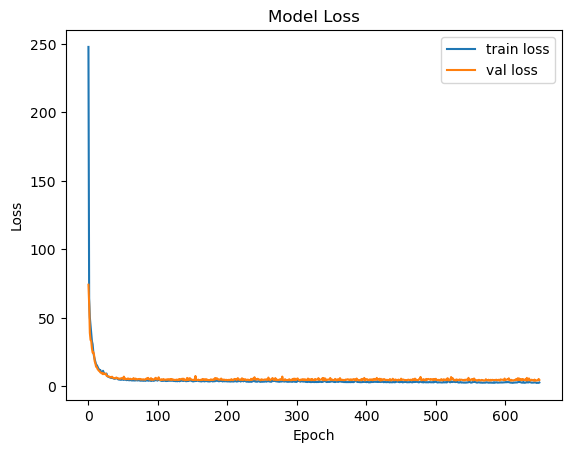

In [70]:
#visualize the training process
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [71]:
#evaluate model on test data
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

6/6 [==============================] - 0s 2ms/step - loss: 4.0446
Test Loss: 4.044569969177246


6/6 [==============================] - 0s 2ms/step


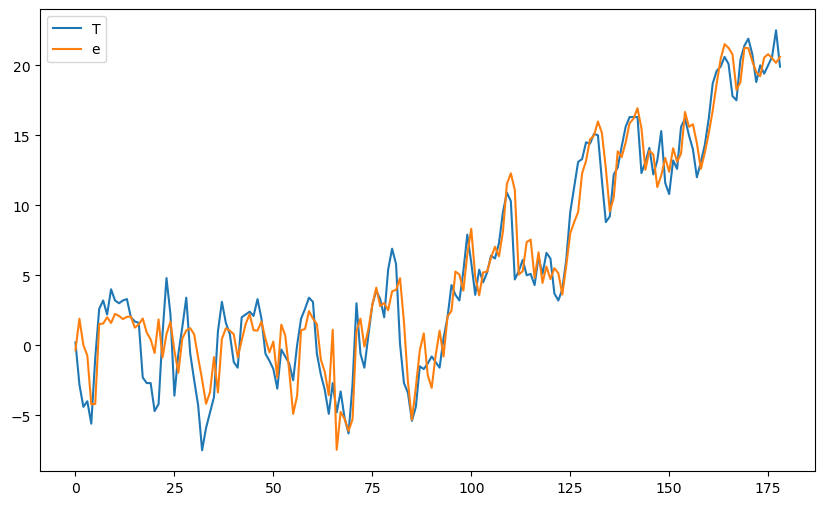

In [72]:
#make predictions
y_pred_scaled = model.predict(X_test)

#inverse transform the scaled predictions and true values
#y_pred = scaler_y.inverse_transform(y_pred_scaled)
#y_test_original = scaler_y.inverse_transform(y_test)

#compare predicted snow depth with actual snow depth
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True Temp(°C)')
plt.plot(y_pred_scaled, label='Predicted Temp (°C)')
plt.legend('Temeprature prediction using LSTM')
plt.show()

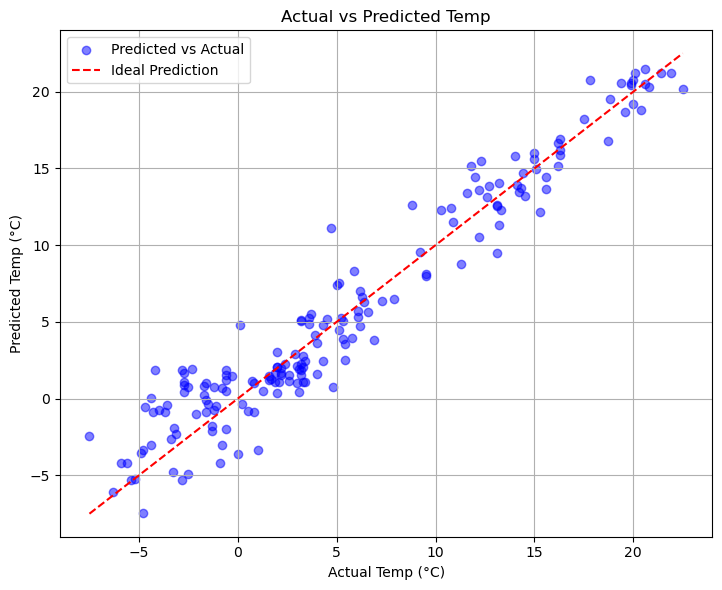

In [73]:
plt.figure(figsize=(14, 6))

# Actual vs Predicted for Temperature
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_scaled, color='blue', alpha=0.5, label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ideal Prediction')
plt.title('Actual vs Predicted Temp')
plt.xlabel('Actual Temp (°C)')
plt.ylabel('Predicted Temp (°C)')
plt.legend()
plt.grid()


plt.tight_layout()
plt.show()

In [74]:
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
mean_absolute_error(y_test, y_pred_scaled)

1.5736324871552059

In [75]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
X = y_test  # Feature (independent variable)
y = y_pred_scaled  # Target (dependent variable)

# Create a LinearRegression model
model = LinearRegression()

# Fit the model
model.fit(X, y)

# Make predictions
y_pred = model.predict(X)

# Calculate the R^2 score
r2 = r2_score(y, y_pred)

print(f"R² score: {r2}")

R² score: 0.9323995651168651
